In [79]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import pandas as pd
import xeofs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from src.configs import *
from src.regions import *
from src.util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Precip Maps and COntribution of Extremes

In [26]:
# Get CMORPH data
pr_files = sorted(glob(f'{project_root()}/data/*.daily_precip.nc'))
assert(len(pr_files)>0)
pr_ds = xr.concat([xr.open_dataset(f).cmorph for f in pr_files], dim='time')
pr_ds = pr_ds.sel({'lat': slice(-30, 30)}).coarsen({'lat': 4, 'lon': 4}).mean()  # Extract the tropical latitudes and coarsen to 1deg

In [27]:
# Get ERA5 omega data
w_files = sorted(glob(f'{project_root()}/data/daily_mean.w.*.nc'))
assert(len(w_files)>0)
w_ds = xr.concat([xr.open_dataset(f).W for f in w_files], dim='time')

In [11]:
# Make sure grids are the same
assert((pr_ds.lat==w_ds.lat).all())
assert((pr_ds.lon==w_ds.lon).all())

In [40]:
# Compute 90%ile of precip rates, and their contribution
p90 = pr_ds.quantile(0.90, dim='time')
p90_contribution = pr_ds.where(pr_ds>=p90, drop=True).sum('time')/pr_ds.sum('time')

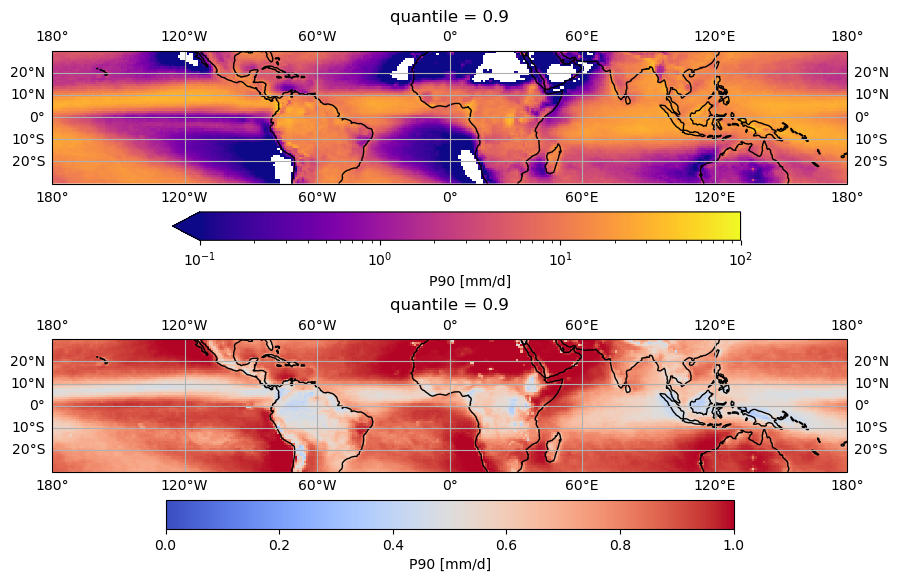

In [46]:
# Plot 90 %ile of precip rate and contribution of extremes to annual total rainfall
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.coastlines()
    ax.gridlines(draw_labels=True)

p90.plot(
    ax=axes[0],
    cmap=plt.cm.plasma.copy(), 
    norm=colors.LogNorm(1e-1, 1e2),
    cbar_kwargs={'orientation': 'horizontal', 'label': 'P90 [mm/d]'}
)
p90_contribution.plot(
    ax=axes[1], 
    cmap=plt.cm.coolwarm.copy(), 
    norm=colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1),
    cbar_kwargs={'orientation': 'horizontal', 'label': 'P90 [mm/d]'}
)

fig.tight_layout(pad=2)

# Mean profiles of precip p-tiles

In [45]:
## Get Equatorial Indian Ocean 
region = EquatorialIndianOcean()

In [46]:
pr_files = sorted(glob(f'{project_root()}/data/*.daily_precip.nc'))
assert(len(pr_files)>0)
pr_ds = xr.concat([xr.open_dataset(f).cmorph for f in pr_files], dim='time')
pr_ds = pr_ds.sel(region.lat_lon_slices).coarsen({'lat': 4, 'lon': 4}).mean()  # Extract the tropical latitudes and coarsen to 1deg

In [47]:
pcs = xr.open_dataarray(f'{project_root()}/data/{region.region_name}.massflux_PCs.nc')
pcs['time'] = pcs['time'].dt.floor('D')
eofs = xr.open_dataarray(f'{project_root()}/data/{region.region_name}.massflux_EOFs.nc')

In [48]:
pcs = pcs.interp({'lat': pr_ds.lat, 'lon': pr_ds.lon})
pcs_normed = pcs/pcs.std(('lat', 'lon', 'time'))
theta = np.arctan2(pcs_normed.sel(mode=2), pcs_normed.sel(mode=1))
theta = theta.transpose('time', 'lon', 'lat')

In [98]:
pr_q = compute_quantiles(pr_ds)
q_bins = np.arange(0.5, 0.999, 0.01)
q_bins = np.logspace(np.log10(0.5), np.log10(0.99), 50)
binned_theta = theta.groupby_bins(pr_q, bins=q_bins).mean()
theta_err = theta.groupby_bins(pr_q, bins=q_bins).std()
theta_N = theta.groupby_bins(pr_q, bins=q_bins).count()

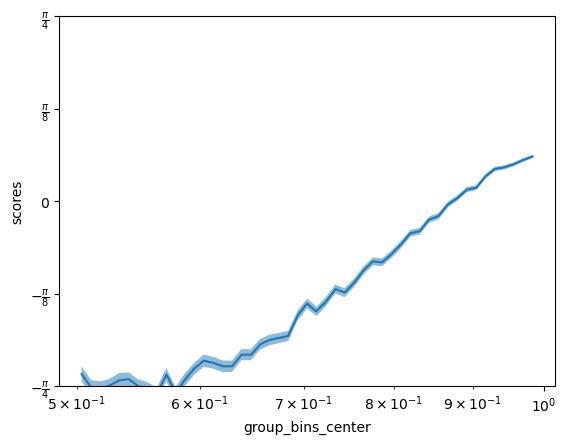

In [99]:
fig, ax = plt.subplots()
binned_theta.plot(ax=ax)
ax.fill_between(array_midpoints(q_bins), binned_theta+(theta_err/np.sqrt(theta_N)), binned_theta-(theta_err/np.sqrt(theta_N)), alpha=0.5)
ax.set_ylim(-np.pi/4, np.pi/4)
yticks = np.arange(-np.pi / 4, np.pi / 4 + np.pi / 8, np.pi / 8)
ax.set_yticks(yticks)

# Set y-axis tick labels with LaTeX formatting
ytick_labels = [r'$-\frac{\pi}{4}$', r'$-\frac{\pi}{8}$', r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$']
ax.set_yticklabels(ytick_labels)
ax.set_xscale('log')

In [83]:
theta_N

<xarray.DataArray 'scores' (group_bins: 49)> Size: 392B
array([6516, 6461, 6602, 6417, 6857, 6556, 6462, 6494, 6621, 6573, 6528,
       6580, 6684, 6562, 6533, 6501, 6643, 6573, 6604, 6548, 6583, 6597,
       6542, 6582, 6600, 6573, 6577, 6590, 6562, 6559, 6580, 6592, 6570,
       6564, 6581, 6566, 6588, 6559, 6594, 6578, 6575, 6572, 6574, 6578,
       6579, 6571, 6578, 6578, 6575])
Coordinates:
  * group_bins  (group_bins) object 392B (0.5, 0.51] ... (0.98, 0.99]
Attributes: (12/14)
    model:         EOF analysis
    software:      xeofs
    version:       3.0.2
    date:          2024-09-20 17:00:59
    n_modes:       10
    center:        True
    ...            ...
    check_nans:    True
    sample_name:   sample
    feature_name:  feature
    random_state:  None
    compute:       True
    solver:        auto